`06-mri-freesurfer-segmentation-bash.ipynb`  (A.L. 2021-04-06)

# Freesurfer (7.1.1) segmentation   (Linux and MacOS only)

### Learning objectives

- Organize and convert DICOM images according to pulse sequence/study number
- Run Freesurfer (7.1.1) segmentation on 3D T1w images using **bash cell magic** with input parameters

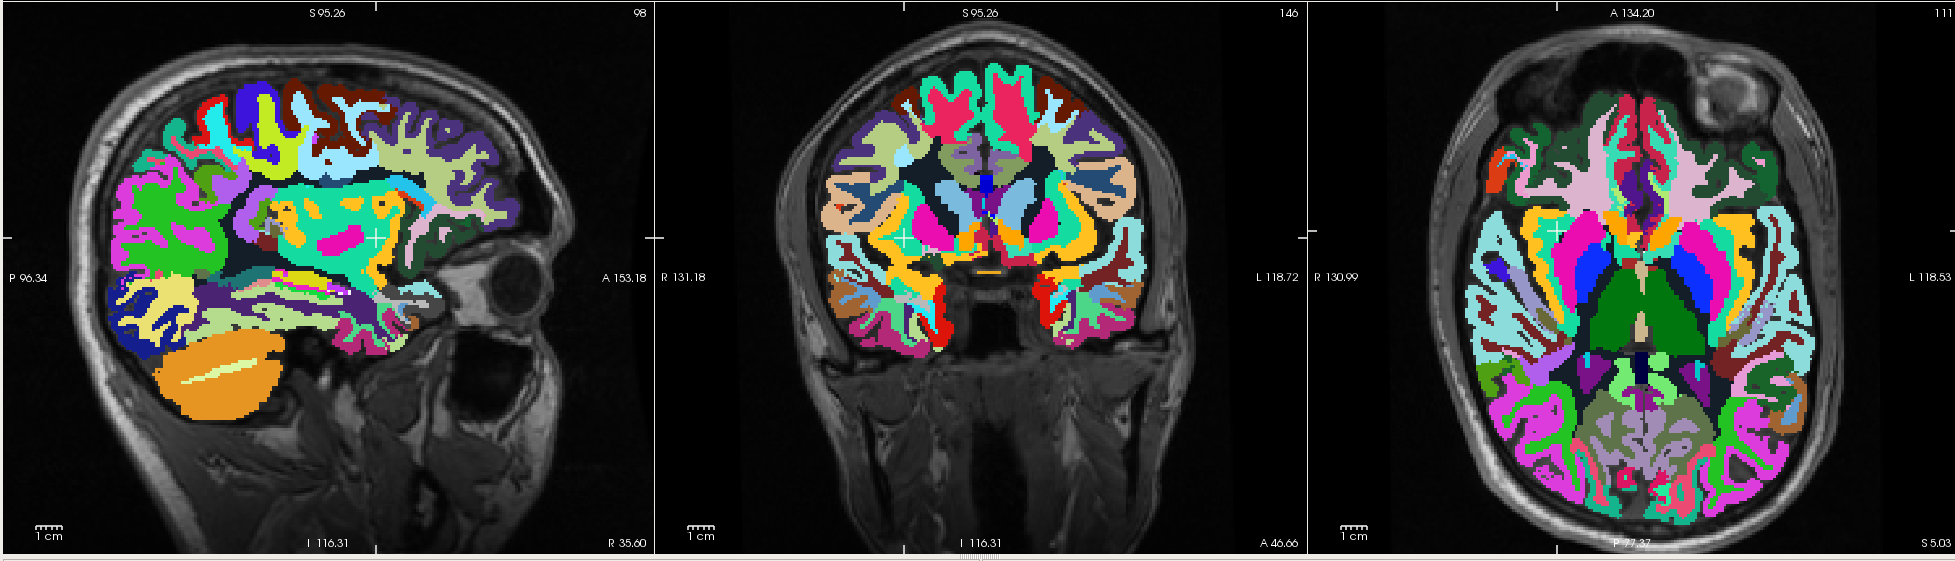

In [1]:
from IPython.display import Image
Image("assets/sub_101_tp1_orig_wmparc.png")

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [50]:
import gdown
import shutil
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

In [58]:
platform.version()

'Darwin Kernel Version 20.3.0: Thu Jan 21 00:07:06 PST 2021; root:xnu-7195.81.3~1/RELEASE_X86_64'

Check your platform for running this notebook

In [59]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'You will not be able to run Freesurfer (unless you install WSL) since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.3.0: Thu Jan 21 00:07:06 PST 2021; root:xnu-7195.81.3~1/RELEASE_X86_64)


In [37]:
HOME = expanduser('~') # To make path to local home directory
basedir = '%s/prj/BMED360' % HOME
destdir = '%s/LG_Prisma_20160218_DICOM' % basedir

In [38]:
# https://drive.google.com/file/d/12Xk4NUAR9VzGfREjtosWQdfZQl_Rc-1m/view?usp=sharing
file_id = '12Xk4NUAR9VzGfREjtosWQdfZQl_Rc-1m'
url = 'https://drive.google.com/uc?id=%s' % file_id
output = '%s/Lab2_LG_Prisma_20160218_DICOM.zip' % basedir

if os.path.isdir(destdir) == False:
    try:
        os.makedirs(destdir , exist_ok = False)
        print("Directory '%s' created successfully" % destdir)
        gdown.download(url, output, quiet=False)
    except OSError as error:
        if os.path.isdir(destdir):
            print("Directory '%s' already exists" % destdir)
        else:
            print("Directory '%s' can not be created" % destdir)
else:
    print(f'Data seems to be downloaded to {destdir} already!')

Data seems to be downloaded to /Users/arvid/prj/BMED360/LG_Prisma_20160218_DICOM already!


In [39]:
# Unpack the gnuziped tar-file (or .zip file) if exists
if os.path.isfile(output) == True:
    shutil.unpack_archive(output, basedir)

In [40]:
# Remove the gnuzipped tar-file (or .zip file) after the unpacking (if exists)
if os.path.isfile(output) == True:
    os.remove(output)

**Import libraries**

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # this is how we usually import pandas
import numpy as np # this is how we usually import numpy
import sys # only needed to determine Python version number
import pathlib
import subprocess as subp
import matplotlib # only needed to determine Matplotlib version number
import pydicom
import scipy
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import nilearn
from nilearn import plotting
import ipywidgets
import itkwidgets
import pyvista as pv
import SimpleITK as sitk

# Enable inline plotting
%matplotlib inline

**Loading series of 2D DICOM files**

In [42]:
try:
    import pydicom as dicom
    print('pydicom package imported successfully!')
except ImportError:
    print ('It seems that you have to install the pydicom package.\n')

pydicom package imported successfully!


Find ALL files from the `Lab2_LG_Prisma_20160218_DICOM.zip` in the `LG_Prisma_20160218_DICOM` folder    

In [43]:
files = os.listdir(destdir)

In [44]:
# select only files (skip floders) 
files = [f for f in files if not os.path.isdir(f)]
# select files with name ends with 'IMA' and sort them
files = sorted([f for f in files if f.endswith('IMA')])  # alternatively: files.sort()
print(f"List contains {len(files)} filenames that ends with 'IMA'")

List contains 1085 filenames that ends with 'IMA'


In [45]:
%%time
# Within these structures there are both metadata and image pixel values
dcms = []
print(f'Loading:')
for f in files:
    # Join folder name and file name
    pth = os.path.join(destdir, f)
    dcms.append(dicom.dcmread(pth))
  
    print(f"{len(dcms)}",end=',')
print(f"\n\nLoaded {len(dcms)} DICOM file structures")

Loading:
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275

**Sort DICOM files to directories according to pulse sequence (i.e. Protocol Name tag)**

In [46]:
pnames = [dcms[i].ProtocolName  for i in range(len(dcms))] 
unique_pnames = list(dict.fromkeys(pnames))
unique_pnames

['localizer',
 't1_mprage_sag_1mm',
 'ep2d_diff_qspace_p2',
 'ep2d_bold_moco_p2_3mm_RS']

In [47]:
# Make new directories acording to Protocol (sequence) Names
seqdir = '%s/Lab2_LG_Prisma_20160218' % basedir

In [48]:
for i, f in enumerate(unique_pnames):
    pth = os.path.join(seqdir, f)
    if os.path.isdir(pth) == False:
        print(pth)
        os.makedirs(pth , exist_ok = False)
    else:
        print(f'Directory {pth} already exits!')

Directory /Users/arvid/prj/BMED360/Lab2_LG_Prisma_20160218/localizer already exits!
Directory /Users/arvid/prj/BMED360/Lab2_LG_Prisma_20160218/t1_mprage_sag_1mm already exits!
Directory /Users/arvid/prj/BMED360/Lab2_LG_Prisma_20160218/ep2d_diff_qspace_p2 already exits!
Directory /Users/arvid/prj/BMED360/Lab2_LG_Prisma_20160218/ep2d_bold_moco_p2_3mm_RS already exits!


In [49]:
%%time
for i, d in enumerate(dcms):
    for p in range(len(unique_pnames)):
        if d.ProtocolName == unique_pnames[p]:
            pth = os.path.join(seqdir, d.ProtocolName, files[i])
            if os.path.isfile(pth) == False:
                shutil.copy(os.path.join(destdir, files[i]), os.path.join(seqdir, d.ProtocolName))
            else:
                print(f'File  #{i} {files[i]} already exits!')

File  #0 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0001.0001.2016.02.18.14.50.53.808776.94904516.IMA already exits!
File  #1 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0001.0002.2016.02.18.14.50.53.808776.94904554.IMA already exits!
File  #2 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0001.0003.2016.02.18.14.50.53.808776.94904539.IMA already exits!
File  #3 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0001.2016.02.18.14.50.53.808776.94909638.IMA already exits!
File  #4 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0002.2016.02.18.14.50.53.808776.94909656.IMA already exits!
File  #5 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0003.2016.02.18.14.50.53.808776.94909674.IMA already exits!
File  #6 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0004.2016.02.18.14.50.53.808776.94909692.IMA already exits!
File  #7 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0005.2016.02.18.14.50.53.808776.94909710.IMA already exits!
File  #8 FOU_160218_BRAIN-GUT_LG.MR.NEVRO_HODE.0002.0006.2016.02.18.14.50.53.808776.94909728.IMA already

### For running Freesurfer 7.1.1 from this notebook
_Modify your Freesurfer home directory on you Mac or your Linix machine_

In [68]:
if platform.system() == 'Darwin':
    FS_HOME = '/Applications/freesurfer/7.1.1'
elif platform.system() == 'Linux':
    FS_HOME = '/usr/local/freesurfer'
else:
    print(f'You will probablly not be able to run Freesurfer on your system ({platform.system()})!')

RECON_ALL = '%s/bin/recon-all' % FS_HOME
print(os.popen(RECON_ALL).read())


USAGE: recon-all

 Required Arguments:
   -subjid <subjid>
   -<process directive>

 Fully-Automated Directive:
  -all           : performs all stages of cortical reconstruction
  -autorecon-all : same as -all

 Manual-Intervention Workflow Directives:
  -autorecon1    : process stages 1-5 (see below)
  -autorecon2    : process stages 6-23
                   after autorecon2, check white surfaces:
                     a. if wm edit was required, then run -autorecon2-wm
                     b. if control points added, then run -autorecon2-cp
                     c. proceed to run -autorecon3
  -autorecon2-cp : process stages 12-23 (uses -f w/ mri_normalize, -keep w/ mri_seg)
  -autorecon2-wm : process stages 15-23
  -autorecon2-inflate1 : 6-18
  -autorecon2-perhemi : tess, sm1, inf1, q, fix, sm2, inf2, finalsurf, ribbon
  -autorecon3    : process stages 24-34
                     if edits made to correct pial, then run -autorecon-pial
  -hemi ?h       : just do lh or rh (default is to 

### Some preparations before running Freesurfer

In [70]:
my_fs711_dir = '%s/prj/BMED360/fs711_subjects' % HOME 

if not os.path.exists(my_fs711_dir):
    os.makedirs(my_fs711_dir)
else:
    print('%s already exists' % my_fs711_dir)

/Users/arvid/prj/BMED360/fs711_subjects already exists


### To run Freesurfer,  adjust the inputs in the two cells below

#### Illustration of using `bash` magic with string input for Freesurfer recon-all, cfr.
https://stackoverflow.com/questions/19579546/can-i-access-python-variables-within-a-bash-or-script-ipython-notebook-c

In [71]:
FSHOME = [FS_HOME] # Typically FS_HOME: on Mac '/Applications/freesurfer/7.1.1', on LINUX '/usr/local/freesurfer'
FS_SUBJ = [my_fs711_dir]  

In [72]:
prjdir = '%s/prj/BMED360' % HOME
subjlist = ['LG_Prisma_20160218']
T1list = ['%s/%s/%s' % (prjdir, subjlist[i], unique_pnames[1]) for i in range(len(subjlist))]

print(subjlist)
print(T1list)

['LG_Prisma_20160218']
['/Users/arvid/prj/BMED360/LG_Prisma_20160218/t1_mprage_sag_1mm']


In [ ]:
%%bash -s  "{" ".join(FSHOME)}" "{" ".join(FS_SUBJ)}" "{" ".join(subjlist)}" "{" ".join(T1list)}"

# Input:
# $1: Freesurfer home directory, e.g. '/usr/local/freesurfer' 
# $2: subjects home directory, e.g. '/home/arvid/prj/BrainGut/GE_Signa3T/fs70_subjects'
# $3: list of subjects to run, e.g. ['sub_101_tp1', 'sub_101_tp2']
# $4: list of original T1w-files (to copy), according to the list of subjects, e.g.
#       ['~/prj/BrainGut/GE_Signa3T/bids_toro/sub-101/ses-1/anat/sub-101_ses-1_T1w.nii.gz',
#        '~/prj/BrainGut/GE_Signa3T/bids_toro/sub-101/ses-2/anat/sub-101_ses-2_T1w.nii.gz']
 
# Output:
#   Freesurfer tree for each of the subjects in the given list

echo $1
echo $2

FREESURFER_HOME=${1}; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=${2}; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh

# PREPARE Data
cd $SUBJECTS_DIR

ii=0
counter=0

for i in $3
do
  echo $i
  # Make FreeSurfer tree for this subject
  mksubjdirs $i
  cd $i
  cd mri/orig
  mkdir 001

  for k in $4
  do
   if [ $counter == $ii ]
   then
      echo $k
      
      # Copy the proper DICOM or NIFTI data to the FS tree
      cp -r $k/*.IMA 001/
      
      # Convert from DICOM to MGZ, getting the first DICOM file in 001/
      cd 001
      files=(*.IMA)
      echo "${files[0]}"
      cd ..
      mri_convert -it dicom -ot mgz 001/${files[0]} 001.mgz
      
      # Start FreeSurfer processing
      cd $SUBJECTS_DIR
      echo '#recon-all -s $i -all -threads 10 >& /dev/null &'
      recon-all -s $i -all -threads 10 >& /dev/null &
      
   fi
   ((counter++))
  done
  ((ii++))
  counter=0

done


`This will take a long time ......` monitor with 'htop' and check  `.../scripts/recon-all.log` occasionally.

On a MacBook Pro 16" 2019, 2.4 GHz 8-core Intel Core i9, 64 GB 2667 MHz DDR4 RAM, 4 TB SSD disk: start 20:13  end 23:08   i.e. ~3 hrs (not bad!)

### Hippocampal subfields and nuclei of the amygdala sub-segmentations

In [ ]:
HC = '/Applications/freesurfer/7.1.1/bin/segmentHA_T1.sh'
print(os.popen('%s --help' % HC).read())

In [ ]:
%%bash -s  "{" ".join(FSHOME)}" "{" ".join(FS_SUBJ)}" "{" ".join(subjlist)}" 

# Input:
# $1: Freesurfer home directory, e.g. '/Applications/freesurfer/7.1.1' or '/usr/local/freesurfer' 
# $2: subjects home directory, e.g. '%s/prj/BMED360/fs711_subjects' % HOME 
# $3: list of subjects to run, e.g. ['LG_Prisma_20160218'] or ['sub_101_tp1', 'sub_101_tp2']
# 
# Output:
#   Freesurfer tree for each of the subjects in the given list

echo $1
echo $2

FREESURFER_HOME=${1}; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=${2}; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh

# PREPARE Data
cd $SUBJECTS_DIR


for i in $3
do
  echo $i
  
  # Do segmentation of the hippocampal subfields and nuclei of the amygdala (T1w)
  segmentHA_T1.sh $i >& /dev/null &
  
done

### Brainstem sub-segmentations

In [ ]:
BS = '/Applications/freesurfer/7.1.1/bin/segmentBS.sh'
print(os.popen('%s --help' % BS).read())

In [ ]:
%%bash -s  "{" ".join(FSHOME)}" "{" ".join(FS_SUBJ)}" "{" ".join(subjlist)}" 

# Input:
# $1: Freesurfer home directory, e.g. '/Applications/freesurfer/7.1.1' or '/usr/local/freesurfer' 
# $2: subjects home directory, e.g. '%s/prj/BMED360/fs711_subjects' % HOME 
# $3: list of subjects to run, e.g. ['LG_Prisma_20160218'] or ['sub_101_tp1', 'sub_101_tp2']
# 
# Output:
#   Freesurfer tree for each of the subjects in the given list

echo $1
echo $2

FREESURFER_HOME=${1}; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=${2}; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh

# PREPARE Data
cd $SUBJECTS_DIR


for i in $3
do
  echo $i
  
  # Do segmentation of brainstem substructures (T1w)
  segmentBS.sh $i >& /dev/null &
  
done

## Freesurfer space to native space using `mri_vol2vol`

(adapted from my https://github.com/arvidl/viola-ibs-imaging/blob/master/notebooks/05-freesurfer-to-native-space.ipynb)

#### How to Convert from FreeSurfer Space Back to Native Anatomical Space
See: https://surfer.nmr.mgh.harvard.edu/fswiki/FsAnat-to-NativeAnat

Question: I have successfully run a subject's data through [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurfer). 
FreeSurfer creates volumes in 1 mm$^3$, 256$^3$ space, but I want the FreeSurfer results in the space of my original anatomical. How do I do this?<br>

The exact command you use depends on what you want to convert, an image (like brain.mgz) or a segmentation (like aseg.mgz).

For an image:

In [73]:
# cd $SUBJECTS_DIR/<subjid>/mri
# mri_vol2vol --mov brain.mgz --targ rawavg.mgz --regheader --o brain-in-rawavg.mgz --no-save-reg

For a segmentation (aseg.mgz, aparc+aseg.mgz, wmparc.mgz, etc):

In [74]:
# cd $SUBJECTS_DIR/<subjid>/mri
# mri_label2vol --seg aseg.mgz --temp rawavg.mgz --o aseg-in-rawavg.mgz --regheader aseg.mgz

Map the surface to the native space:

In [75]:
# mri_surf2surf --sval-xyz pial --reg register.native.dat rawavg.mgz --tval lh.pial.native --tval-xyz rawavg.mgz --hemi lh --s subjectname

The output will be stored in 
```bash
$SUBJECTS_DIR/subjectname/surf/lh.pial.native 
```
and can be viewed with 
```bash
freeview rawavg.mgz -f ../surf/lh.pial.native
```
To verify that this worked, run

In [78]:
# freeview -v rawavg.mgz -f lh.pial.native

In [77]:
MRI_VOL2VOL = '%s/bin/mri_vol2vol' % FS_HOME
print(os.popen(MRI_VOL2VOL).read())


mri_vol2vol

  --mov  movvol       : input (or output template with --inv)
  --targ targvol      : output template (or input with --inv)
  --o    outvol       : output volume
  --disp dispvol      : displacement volume
  --downsample N1 N2 N3 : downsample input volume (do not include a targ or regsitration)
         sets --fill-average, --fill-upsample 2, and --regheader

  --reg  register.dat : tkRAS-to-tkRAS matrix   (tkregister2 format)
  --lta  register.lta : Linear Transform Array (usually only 1 transform)
  --lta-inv  register.lta : LTA, invert (may not be the same as --lta --inv with --fstal)
  --fsl  register.fsl : fslRAS-to-fslRAS matrix (FSL format)
  --xfm  register.xfm : ScannerRAS-to-ScannerRAS matrix (MNI format)
  --regheader         : ScannerRAS-to-ScannerRAS matrix = identity
  --mni152reg         : target MNI152 space (need FSL installed)
  --s subject         : set matrix = identity and use subject for any templates

  --inv               : sample from targ to mov


In [ ]:
def my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype):
    """
    Ex. 
    cd $SUBJECTS_DIR/<subjid>/mri
    mri_vol2vol --mov brain.mgz --targ rawavg.mgz --regheader --o brain-in-rawavg.mgz --no-save-reg
    --interp interptype : interpolation cubic, trilin, nearest (def is trilin)
    """
    
    #os.chdir(join('%s' % (subj_dir), 'sub_%d_tp%d/mri' % (sub, ses)))
    # fs_mri = join('%s' % (subj_dir), 'sub_%d_tp%d/mri' % (sub, ses))  # if FS_tree = 'fs60_subjects
    fs_mri = join('%s' % (subj_dir), 'subj_%d_tp%d/mri' % (sub, ses))   # if FS_tree = 'subjects_fs600'
    cmd = [
            MRI_VOL2VOL,
            '--mov', '%s/%s.mgz' % (fs_mri, inp_image),
            '--targ', '%s' % (targ_image),
            '--regheader', 
            '--interp', '%s' % (interptype),
            '--o', '%s/sub_%d_tp%d_%s_in_%s.nii.gz' % (out_dir, sub, ses, inp_image, targ_name),
            '--no-save-reg']
          #  ' 2>', error_output_log,'>', output_log]   
    cmd_str = " ".join(cmd)
    #print('cmd_str = \n%s\n' % cmd_str)
        
    # EXECUTE
    os.system(cmd_str)

#### Testing the native space conversion on one subject using the `_T1_biascorr_brain.nii.gz` image obtained from `03-fsl-anat.ipynb` as target image.

In [ ]:
working_dir = join(home, 'prj','BrainGut','GE_Signa3T')
subj_dir = '%s/%s' % (working_dir, FS_tree) 
out_dir = '%s/dipy_analysis' % (working_dir)

sub = 101
ses = 1

targ_name = 'native_space'
targ_image = join(out_dir,'sub_%d_tp%d_T1_biascorr_brain.nii.gz' % (sub, ses))

**Use the `my_mri_vol2vol()`function on different source images and masks using approriate interpolation ('trilinear' and 'nearest neighbour')**

In [ ]:
interptype = 'trilin'
inp_image = 'brain'
my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

interptype = 'nearest'
inp_image = 'ribbon'
my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

interptype = 'nearest'
inp_image = 'aseg'
my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

interptype = 'nearest'
inp_image = 'wmparc'
my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

interptype = 'nearest'
inp_image = 'aparc+aseg'
my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

#### Run the native space conversion on all subjects and sessions using the `_T1_biascorr_brain.nii.gz` image obtained from `03-fsl-anat.ipynb` as target image.

In [ ]:
%%time
working_dir = join(home, 'prj','BrainGut','GE_Signa3T')
bids_dir = '%s/bids_toro' % (working_dir)
fsl_anat_dir = '%s/fsl_anat_toro' % (working_dir)
subj_dir = '%s/%s' % (working_dir, FS_tree) 
out_dir = '%s/dipy_analysis' % (working_dir)
targ_name = 'native_space'

nsubj = 30

for i in utils.progressbar(range(nsubj), "Computing: ", 40):
    time.sleep(0.1)
    sub = i+101
    for ses in [1, 2]:
        
        targ_image = join(bids_dir,'sub-%d/ses-%d/anat/sub-%d_ses-%d_T1w.nii.gz' % (sub, ses, sub, ses))
        out_targ_image = join(out_dir,'sub_%d_tp%d_T1w.nii.gz' % (sub, ses))
        
        
        inp_fsl_t1_brain_image = join(fsl_anat_dir,'sub-%d_ses-%d.anat/T1_biascorr_brain.nii.gz' % (sub, ses))
        inp_fsl_t1_brain_mask = join(fsl_anat_dir,'sub-%d_ses-%d.anat/T1_biascorr_brain_mask.nii.gz' % (sub, ses))
        inp_fsl_t1_subcort_seg = join(fsl_anat_dir,'sub-%d_ses-%d.anat/T1_subcort_seg.nii.gz' % (sub, ses))
        
        out_fsl_t1_brain_image = join(out_dir,'sub_%d_tp%d_T1_biascorr_brain.nii.gz' % (sub, ses))
        out_fsl_t1_brain_mask = join(out_dir,'sub_%d_tp%d_T1_biascorr_brain_mask.nii.gz' % (sub, ses))
        out_fsl_t1_subcort_seg = join(out_dir,'sub_%d_tp%d_T1_subcort_seg.nii.gz' % (sub, ses))
        
        shutil.copy2(targ_image, out_targ_image)
        
        shutil.copy2(inp_fsl_t1_brain_image, out_fsl_t1_brain_image)
        shutil.copy2(inp_fsl_t1_brain_mask, out_fsl_t1_brain_mask)
        shutil.copy2(inp_fsl_t1_subcort_seg, out_fsl_t1_subcort_seg)
        
        
        inp_image = 'orig'
        interptype = 'trilin'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)
        
        inp_image = 'brain'
        interptype = 'trilin'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

        
        inp_image = 'brainmask'
        interptype = 'nearest'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)
                       
        inp_image = 'ribbon'
        interptype = 'nearest'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

        inp_image = 'aseg'
        interptype = 'nearest'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

        inp_image = 'wmparc'
        interptype = 'nearest'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)

        inp_image = 'aparc+aseg'
        interptype = 'nearest'
        my_mri_vol2vol(subj_dir, sub, ses, inp_image, targ_image, targ_name, out_dir, interptype)